## The goal of this project is to utilize machine learning or artificial intelligence, specifically employing image classification algorithms, for the categorization of three primary types of brain tumors: gliomas, meningiomas, and pituitary tumors. 

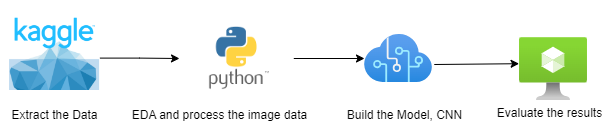

In [2]:
import os
os.chdir('E:\\Sandeep_Fall_2023\\04-CIS-8694-AI-For-Decision-Making\\Project')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import PIL 
import tensorflow as tf 
import cv2
import shutil
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Input

In [4]:
data_dir = 'archive'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

In [5]:
#Define Categories
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

# Plotting Sample images from data set

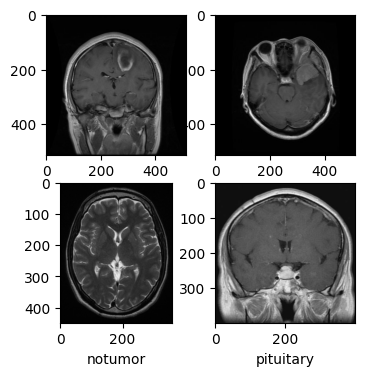

In [7]:
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel('glioma')
sample1 = os.path.join(train_dir, 'glioma', 'Tr-gl_0100.jpg')
img = mpimg.imread(sample1)
imgplot = plt.imshow(img)
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel('meningioma')
sample2 = os.path.join(train_dir, 'meningioma', 'Tr-me_0029.jpg')
img2 = mpimg.imread(sample2)
imgplot = plt.imshow(img2)
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_xlabel('notumor')
sample3 = os.path.join(train_dir, 'notumor', 'Tr-no_0039.jpg')
img3 = mpimg.imread(sample3)
imgplot = plt.imshow(img3)
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_xlabel('pituitary')
sample4 = os.path.join(train_dir, 'pituitary', 'Tr-pi_0029.jpg')
img4 = mpimg.imread(sample4)
imgplot = plt.imshow(img4)
plt.show()

# Total Images for each Image category in dataset

{'glioma': 2642, 'meningioma': 2678, 'notumor': 3190, 'pituitary': 2914}


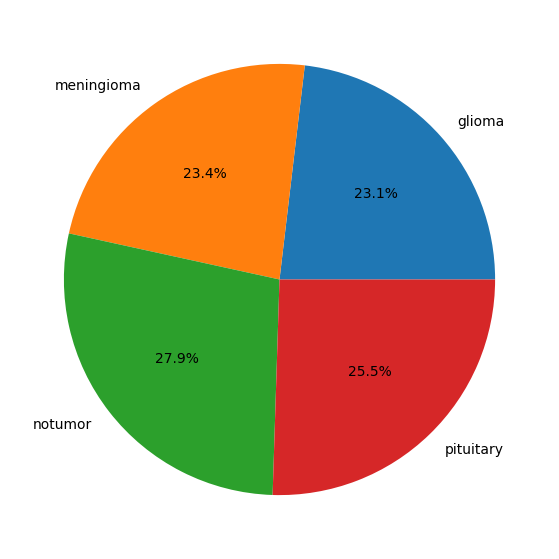

In [8]:
Image_categories = {}
for category in CATEGORIES:
    Image_categories[category] = len(os.listdir(os.path.join(train_dir, category)))
for category in CATEGORIES:
    Image_categories[category] = Image_categories[category] + len(os.listdir(os.path.join(train_dir, category)))

print(Image_categories)
fig = plt.figure(figsize =(10, 7))
plt.pie(Image_categories.values(), labels = Image_categories.keys(), autopct='%1.1f%%')
plt.show()

In [9]:
def load_data(dataset_path, labels):
    """ Load each label dataset into list.
    Parameters:
        dataset_path(str): Name of the path for dataset.
        labels(str): Name of the path for the label dataset.
    Returns: 2 lists of data & labels
    """

    X = []
    y = []
    for label in labels:
        label_data = os.path.join(dataset_path, label)
        for filename in os.listdir(label_data):
            file_path = os.path.join(label_data, filename)
            image = cv2.imread(file_path)
            X.append(image)
            y.append(labels.index(label))

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    return X, y

def preprocess_image(image, size=256):
    # Resize image
    image = cv2.resize(image, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

    # Normalize the image
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # remove images noise.
    image = cv2.bilateralFilter(image, 2, 50, 50)

    image = (image * 255).astype(np.uint8)

    return image

In [10]:
def preprocess_data(source_path, destination_path, img_size=256):
    if os.path.exists(destination_path):
        shutil.rmtree(destination_path)
    os.makedirs(destination_path)
    for root, dirs, files in os.walk(source_path):
        sub_dir = os.path.relpath(root, source_path)
        path = os.path.join(destination_path, sub_dir)
        if not os.path.exists(path):
            os.makedirs(os.path.join(destination_path, sub_dir))
        if files:
            for file in files:
                if not file.endswith('.jpg'):
                    continue

                # Read the original image
                original_path = os.path.join(root, file)
                img = cv2.imread(original_path)
                processed_img = preprocess_image(img, img_size)

                # Save the optimized image
                processed_path = os.path.join(destination_path, sub_dir, file)
                cv2.imwrite(processed_path, processed_img)

# Process the data, resize the images into required size and create processed dataset

In [11]:
dataset_path = 'E:\\Sandeep_Fall_2023\\04-CIS-8694-AI-For-Decision-Making\\Project\\archive'
processed_dataset = 'E:\\Sandeep_Fall_2023\\04-CIS-8694-AI-For-Decision-Making\\Project\\processed'
preprocess_data(dataset_path, processed_dataset)


# Combining all data and splitting into training and testing 

In [12]:
train_path = os.path.join(processed_dataset, "Training")
test_path = os.path.join(processed_dataset, "Testing")
labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

X, y = load_data(train_path, labels)
X_test, y_test = load_data(test_path, labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# Build the Model

we are building a simple Convolutional Neural Network (CNN) with a few layers that are commonly used for image processing tasks.

A basic CNN architecture for image classification usually consists of convolutional layers, followed by pooling layers, then one or more fully connected layers (also known as dense layers), and a final output layer.

So we decide to build a simple Convolutional Neural Network (CNN) with a few convolutional layers and max pooling layers, followed by a fully connected layer with a sigmoid activation function.

Our model here designed to take in images of size (256, 256, 1) and output a multi-class classification indicating the type of brain tumor.

In [19]:
def build_sequential_model(input_shape, num_classes):
    model = Sequential()

    # Add layers to the model
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [20]:
model = build_sequential_model((256,256,3), NUM_CATEGORIES)

# print a summary of the network layers.

In [21]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the nodel

In [23]:
model.fit(X_train, y_train, batch_size=64, epochs=4, validation_data=(X, y))

Epoch 1/4
63/63 [==============================] - 151s 2s/step - loss: 47.4074 - accuracy: 0.6656 - val_loss: 0.3567 - val_accuracy: 0.8806
Epoch 2/4
63/63 [==============================] - 136s 2s/step - loss: 0.2747 - accuracy: 0.9077 - val_loss: 0.1666 - val_accuracy: 0.9482
Epoch 3/4
63/63 [==============================] - 141s 2s/step - loss: 0.1011 - accuracy: 0.9677 - val_loss: 0.1287 - val_accuracy: 0.9629
Epoch 4/4
63/63 [==============================] - 135s 2s/step - loss: 0.0406 - accuracy: 0.9892 - val_loss: 0.1465 - val_accuracy: 0.9601


# Evaluate the model

In [24]:
eval = model.evaluate(x=X_test, y=y_test)

41/41 [==============================] - 10s 242ms/step - loss: 0.3581 - accuracy: 0.8932


In [25]:
y_pred = model.predict(X_val)

54/54 [==============================] - 13s 236ms/step


# Print the classification report 

In [26]:
y_val_pred_arg = y_pred.argmax(axis=1)
print(classification_report(y_val, y_val_pred_arg))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       411
           1       0.96      0.94      0.95       482
           2       0.84      0.89      0.87       414
           3       0.86      0.75      0.80       407

    accuracy                           0.89      1714
   macro avg       0.89      0.89      0.89      1714
weighted avg       0.89      0.89      0.89      1714

